# Calculating $g$

This notebook was made to calculate the local gravitational acceleration $g [\text{m/s}^2]$.

The data used is stored in `/data`.

The results are stored in `/images` and `/exports`.

Part of the funcions used are stored in `/packages`.

## Modello Fisico

Vogliamo calcolare $g$ tramite un pendolo semplice (reale).

Eq. differenziale del moto armonico:
$$\ddot{\theta} + \frac{g}{L} \theta = 0$$
Da cui troviamo:
$$T = 2 \pi \sqrt{\frac{L}{g}}$$
Da tutto ciò ricaviamo:
$$g = 4 \pi^2 \frac{L}{T^2}$$
Deviazione standard su $g$:
$$\sigma_g = 4\pi^2\sqrt{\left(\frac{1}{T^2}\right)^2_{\langle T\rangle}\sigma_L^2 + \left(\frac{2L}{T^3}\right)^2_{\langle T\rangle, \langle L\rangle}\sigma_T^2}$$
Tuttavia non siamo in un caso ideale, quindi dobbiamo considerare una correzione:
$$T = 2 \pi \sqrt{\frac{L}{g}} \pm \Delta_T$$
Correzione dell'ampiezza:
$$T = 2 \pi \sqrt{\frac{L}{g}} \left( 1 + \frac{\vartheta^2_\text{max}}{16} \right)$$
Differenza dal periodo ideale:
$$D_T= 2 \pi \sqrt{\frac{L}{g}} \left(\frac{\vartheta^2_\text{max}}{16} \right)$$
Incertezza relativa su $g$:
$$\frac{\sigma_g}{g} = \sqrt{\left(\frac{\sigma_L}{L}\right)^2 + \left(2\frac{\sigma_T}{T}\right)^2}$$

Correzione di $T$ a causa dell'attrito viscoso:
$$T^2 \approx T^2_0\left(1 + \frac{\gamma^2}{4\pi^2} \right)$$
??? Ricavare $\gamma$ tramite il modello esponenziale:
$$f(x) = a e^{bx} + c e^{dx}$$

Correzione di $T$ a causa del momento d'inerzia:
$$T = 2\pi \sqrt{\frac{I}{mgL}} = 2\pi \sqrt{\frac{mL^2 + I_{CM}}{mgL}} = T = 2 \pi \sqrt{\frac{L}{g}} \pm \Delta_T$$
Possiamo trovare che il momento d'inerzia non è sempre trascurabile (filo non considerato):
$$\frac{\ell_{eq}}{L} = \frac{\frac{I}{mL}}{L} \approx 1.001$$

Da cui troviamo che:
$$g = g_\text{modello armonico} \pm \sigma_g + Dg_{\vartheta_{max}} + Dg_\text{attrito} + Dg_\text{momento inerzia}$$

## importing libraries

In [51]:
import os
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from packages.funcs import Statistics, Utils

## Load data

### Delete first oscillations

Le oscillazioni iniziali sono affette da vibrazioni, bisogna quindi rimuoverle

In [52]:
def read_csv(filename: str):
    data = pd.read_csv(filename, sep=";").replace(",", ".", regex=True).convert_dtypes()

    # data.dropna(inplace=True)
    # data.drop(index=data.index[0], axis=0, inplace=True)

    return data


def read_excel(filename: str):
    data = pd.read_excel(
        filename,
        # sheet_name="",
    )
    return data

In [53]:
datasets = dict()

for root, dirs, files in os.walk("./data"):
    for file in files:
        current_file_path = os.path.join(root, file)
        if "xlsx" in file:
            datasets[file.rstrip(".xlsx")] = read_excel(current_file_path)
        elif "csv" in file:
            datasets[file.rstrip(".csv")] = read_csv(current_file_path)
else:
    del root, dirs, file, files, current_file_path

data_keys = datasets.keys()


# this should be removed after checking that it works
def show_info(dataset_key: str) -> None:
    print(f"\nkey: {dataset_key}")
    datasets[dataset_key].info()


# this should be removed after checking that it works
Utils.iterate_func_through_keys(data_keys, show_info)


key: example
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Index    59 non-null     int64  
 1   Periods  59 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.1 KB


### Show our data

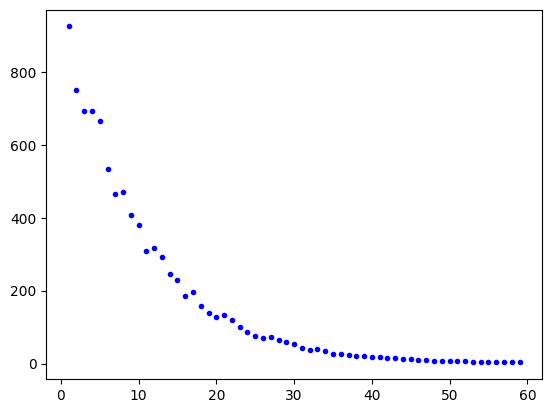

In [54]:
def plot_raw_data(dataset_name: str) -> None:
    plt.scatter(
        datasets[dataset_name].iloc[:, 0],
        datasets[dataset_name].iloc[:, 1],
        c="b",
        marker=".",
    )


Utils.iterate_func_through_keys(data_keys, plot_raw_data)

## Errors

### nominal errors

In [55]:
errori_nominali = {
    "metro": 0.001,  # 1mm
    "calibro": 0.00005,  # 0.05mm
    "bilancia": 0.00001,  # 0.01g
    "cronometro": 0.01,  # s
    "foto_traguardo": 0.0001 * np.sqrt(2),  # s
}

### get the minimal error on periods 

In [56]:
Utils.iterate_func_through_keys(data_keys, Utils.calculate_min_std_dev)

## Statistical analysis

### Expected results

In [57]:
expected_datasets = dict()

# ! this doesn't work
A, B, eA, eB = Statistics.expfit(
    datasets["example"].iloc[:, 0], datasets["example"].iloc[:, 1]
)
expected_datasets["example"] = np.exp(np.array(datasets["example"].iloc[:, 0]) * B) * A

/var/folders/h4/lp363j8s0xd_71n6qf896t0r0000gn/T/ipykernel_1125/4248363659.py:7: RuntimeWarning: overflow encountered in exp
  expected_datasets["example"] = np.exp(np.array(datasets["example"].iloc[:, 0]) * B) * A


### linear regression

In [58]:
Utils.iterate_func_through_keys(data_keys, Statistics.linfit)

### Compatibility test

Test per vedere se i coefficienti sono compatibili con lo zero

### $\chi^2$

In [ ]:
Utils.iterate_func_through_keys(data_keys, Statistics.chi2)

### T-Student

In [ ]:
Utils.iterate_func_through_keys(data_keys, Statistics.t_student)

## Save data

Per avere i dati pronti per essere caricati sulla relazione.

### save graphs

In [59]:
def plot_data(dataset_name: str) -> None:
    plt.figure(figsize=(16, 9), layout="constrained")
    plt.title("TITLE")
    plt.xlabel("XLABEL")
    plt.ylabel("YLABEL")

    plt.plot(
        expected_datasets[dataset_name].x,
        expected_datasets[dataset_name].y,
        c="r",
        ls=":",
    )
    plt.errorbar(
        datasets[dataset_name].real.x,
        datasets[dataset_name].real.x,
        xerr=datasets[dataset_name].real.err_x,
        yerr=datasets[dataset_name].real.err_y,
        ls="",
        c="k",
        marker="x",
    )

    plt.legend(["Regressione lineare", "Misure effettuate"])

    plt.minorticks_on()
    plt.grid(which="major", ls="-", lw=0.7)
    plt.grid(which="minor", ls="--", lw=0.5)

    plt.savefig(
        fname=f"images/{dataset_name}",
        transparent=True,
        dpi=200,
        format="svg",
        metadata={
            "Author": "Mattia Ballico",
            "Contributor": ["Matilde Cappelli", "Filippo Cozzi"],
            "Software": "matplotlib",
            "Description": "LONG DESCRIPTION",
        },
    )
    pass


# Utils.iterate_func_through_keys(data_keys, plot_data)

### save data in latex documents

In [60]:
# clear previous data
with open("exports/results.tex", "w"):
    pass

In [61]:
# random dataframe (as an example)
df = pd.DataFrame(np.random.random((5, 5)))

# save data in .tex file/files
with open("exports/results.tex", "a") as file:
    file.write(
        df.to_latex(
            index=False,
            # column = ["col1", "col2"]
            float_format="{:0.2f}".format,
            caption="caption",
            label="label",
        ),
    )

    file.close()

del file